In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import shap
import seaborn as sns 
import matplotlib.pyplot as plt

# Assuming df is your DataFrame after aggregating to daily data and merging with weather/building data
df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# Get the number of rows and columns 
# rows = len(df.axes[0]) 
# cols = len(df.axes[1]) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41666 entries, 0 to 41665
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               41664 non-null  object 
 1   Comms and Services                 40812 non-null  float64
 2   Car Chargers                       40812 non-null  float64
 3   Space Heating                      40812 non-null  float64
 4   Hot Water                          40812 non-null  float64
 5   Sockets                            40812 non-null  float64
 6   Lighting                           40812 non-null  float64
 7   total_energy                       41664 non-null  object 
 8   datepart                           41664 non-null  float64
 9   weekend                            41664 non-null  object 
 10  bank holiday                       41664 non-null  object 
 11  hour                               41664 non-null  flo

C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_39540\267611544.py:17: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"


In [31]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [32]:

# df['month'] = df.datetime.dt.month
df = encode(df, 'month', 12)
df =  encode(df, 'hour', 24)
# df['day'] = df.datetime.dt.day
# df = encode(df, 'day', 31)
df = encode(df, 'day of week', 7)
df = encode(df, 'day of month', 31)
df['working_hours'] = df['hour'].apply(lambda x: 8 <= x < 17)

In [33]:
# Sum specified columns to create 'total_aob_energy'
df['total_aob_energy'] = df[['Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting']].sum(axis=1, skipna=True)

# Drop the original columns except 'Car Chargers'
df.drop(['Car Chargers','Comms and Services', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting','day of week','day of month','hour','month' ], axis=1, inplace=True)

# Now, 'df' contains the new 'total_aob_energy' column and has the specified columns dropped, except 'Car Chargers'

In [34]:
columns_to_drop = [col for col in df.columns if col.startswith('observation')]

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41666 entries, 0 to 41665
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               41664 non-null  object 
 1   total_energy                       41664 non-null  object 
 2   datepart                           41664 non-null  float64
 3   weekend                            41664 non-null  object 
 4   bank holiday                       41664 non-null  object 
 5   year                               41664 non-null  float64
 6   forecast_datadate                  41664 non-null  object 
 7   forecastperiod                     40766 non-null  object 
 8   forecast_temperature               40766 non-null  float64
 9   forecast_feelslike                 40766 non-null  float64
 10  forecast_weathertype               40766 non-null  float64
 11  forecast_windspeed                 40766 non-null  flo

In [35]:
df.dropna(inplace=True)
df = df.select_dtypes(exclude=['object'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40766 entries, 112 to 41663
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   datepart                           40766 non-null  float64
 1   year                               40766 non-null  float64
 2   forecast_temperature               40766 non-null  float64
 3   forecast_feelslike                 40766 non-null  float64
 4   forecast_weathertype               40766 non-null  float64
 5   forecast_windspeed                 40766 non-null  float64
 6   forecast_uvindex                   40766 non-null  float64
 7   forecast_precipitationprobability  40766 non-null  float64
 8   month_sin                          40766 non-null  float64
 9   month_cos                          40766 non-null  float64
 10  hour_sin                           40766 non-null  float64
 11  hour_cos                           40766 non-null  float6

In [36]:
# Split data into features and target
X = df.drop(['datepart','year','total_aob_energy'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = df['total_aob_energy']
# X = df[['hour_sin','hour_cos','Car Chargers','forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# X = df[['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','observation_temperature','observation_windspeed','observation_pressure','hour' , 'day of week','day of month' ,'month_sin','month_cos',]] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Model Training

In [37]:
lr_model = LinearRegression().fit(X, y)
y_pred_lr = lr_model.predict(X_test)



In [38]:
y_range = np.max(y_test) - np.min(y_test)
# Calculate the mean of the target variable
y_mean = np.mean(y_test)
# Calculate RMSE for Linear Regression
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
# Calculate Normalised RMSE for Linear Regression
lr_nrmse = lr_rmse / y_range
# Calculate rRMSE (relative RMSE) for Linear Regression, normalized by the mean of y_test
lr_rrmse = lr_rmse / y_mean
# Calculate MAE
lr_mae = np.mean(np.abs(y_test - y_pred_lr))
print("Mean Absolute Error (MAE) for Linear Regression:", lr_mae)
# Calculate MAPE
# Note: We add a small number to the denominator to avoid division by zero in case y_test contains zeros.
lr_mape = np.mean(np.abs((y_test - y_pred_lr) / (y_test + 1e-10))) * 100
print("Mean Absolute Percentage Error (MAPE) for Linear Regression:", lr_mape, "%")

print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression NRMSE:", lr_nrmse)
print("Linear Regression rRMSE:", lr_rrmse)

Mean Absolute Error (MAE) for Linear Regression: 0.6780383272565571
Mean Absolute Percentage Error (MAPE) for Linear Regression: 7435453494.59838 %
Linear Regression RMSE: 0.9485319300919778
Linear Regression NRMSE: 0.098830172519683
Linear Regression rRMSE: 0.4653927081157291


In [39]:

lr_model.score(X, y)
lr_model.coef_

array([ 0.15603661, -0.2322398 ,  0.0129764 , -0.03325502,  0.03126113,
       -0.00126906,  0.1226125 ,  0.36270313,  0.30350158, -0.37475137,
        0.20897787, -0.25992837,  0.06087608, -0.09708154, -0.05459619])

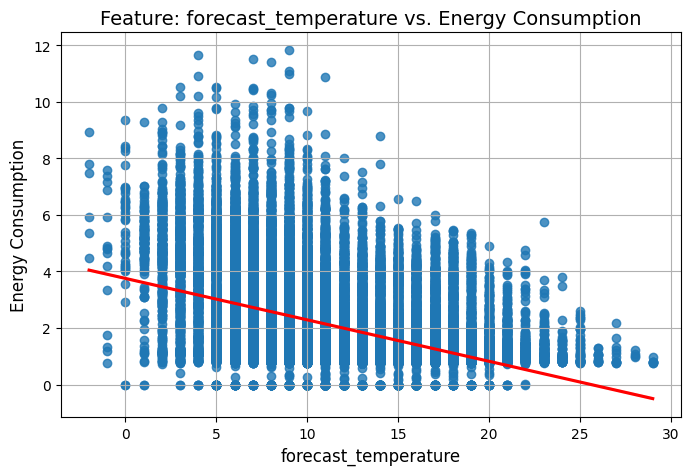

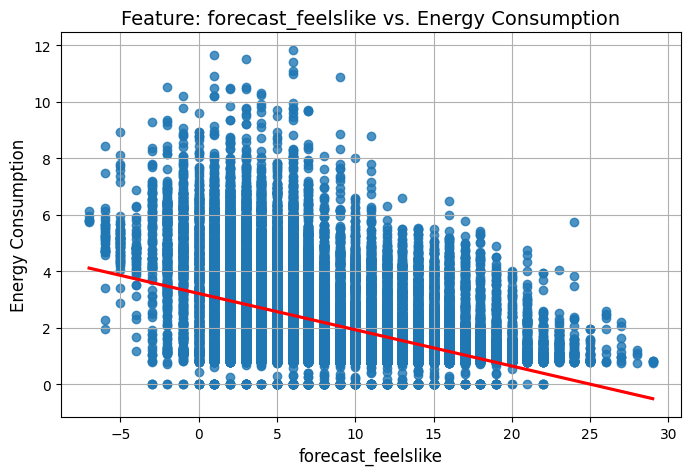

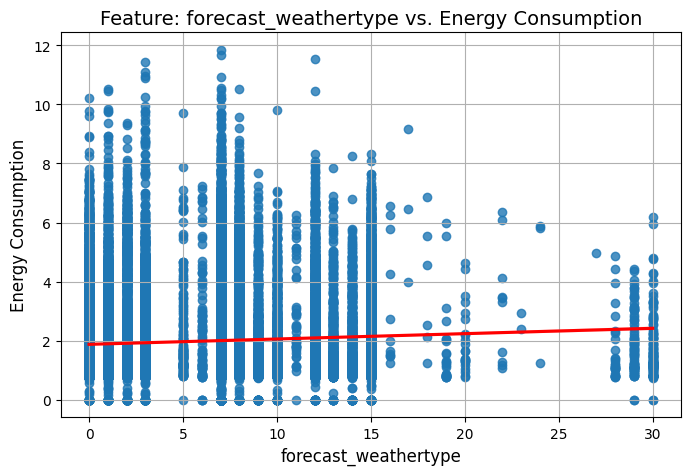

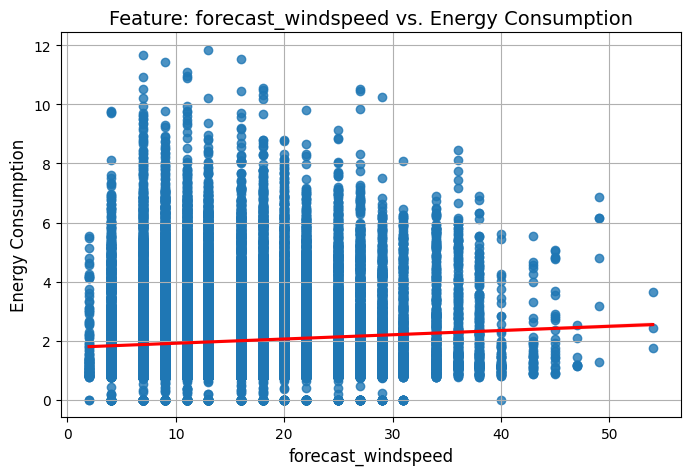

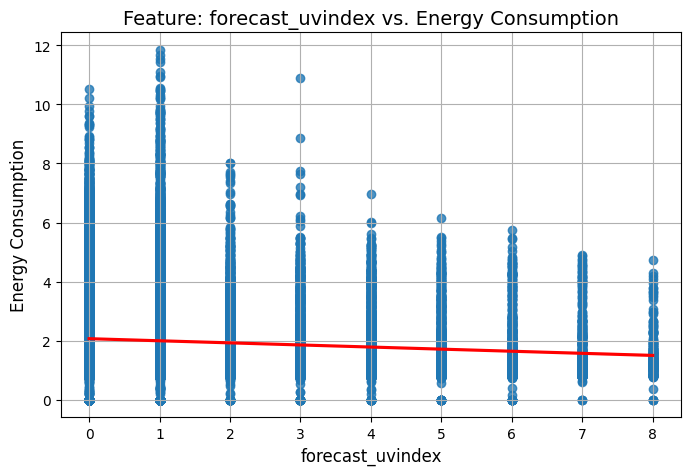

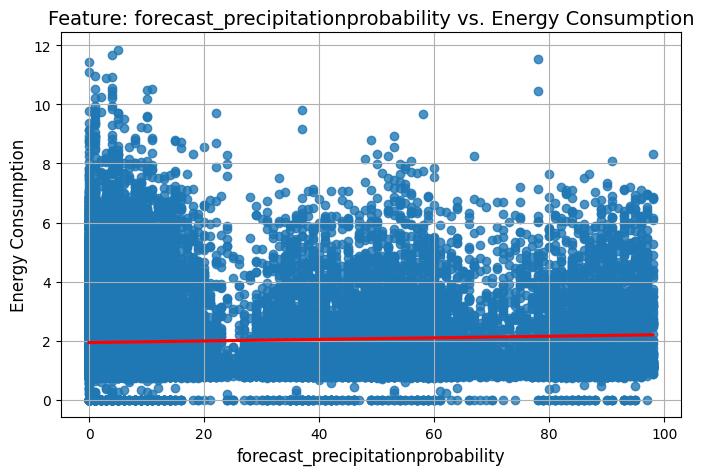

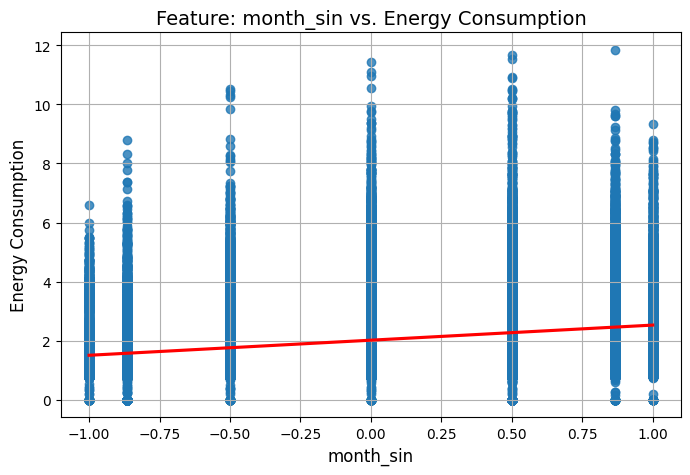

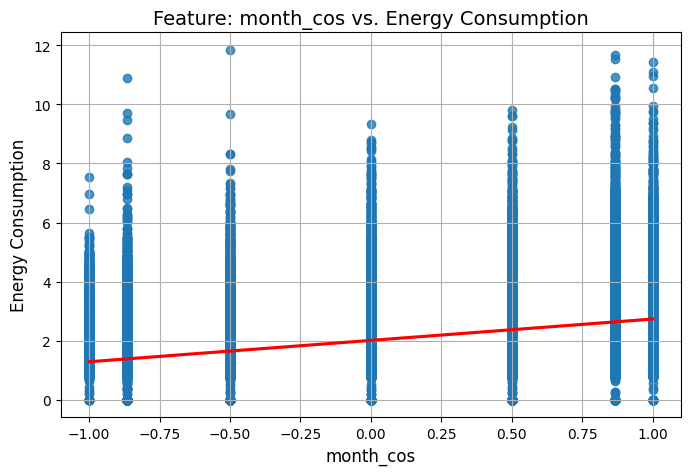

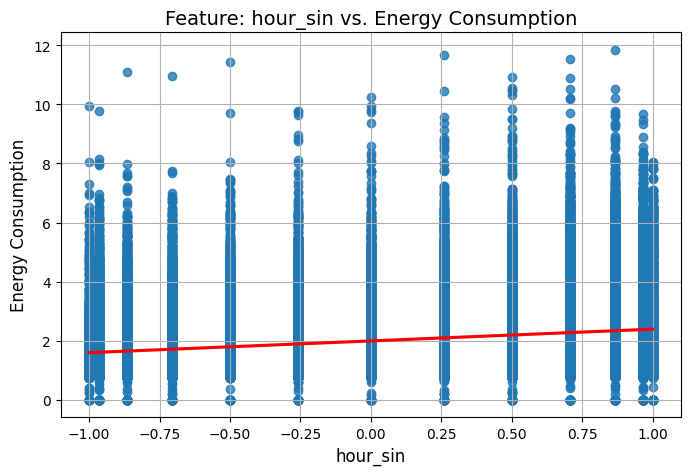

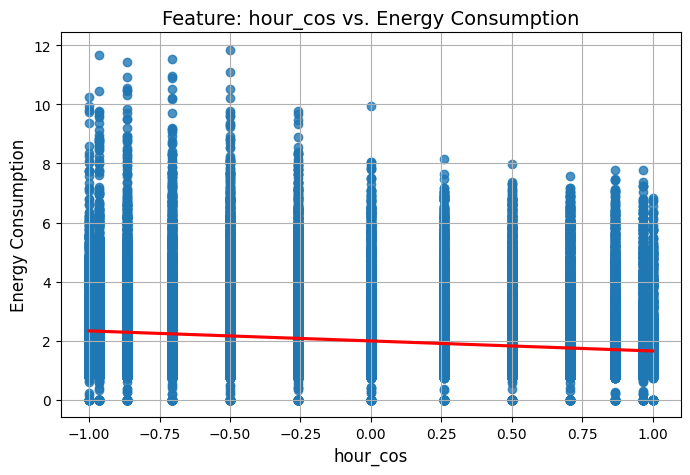

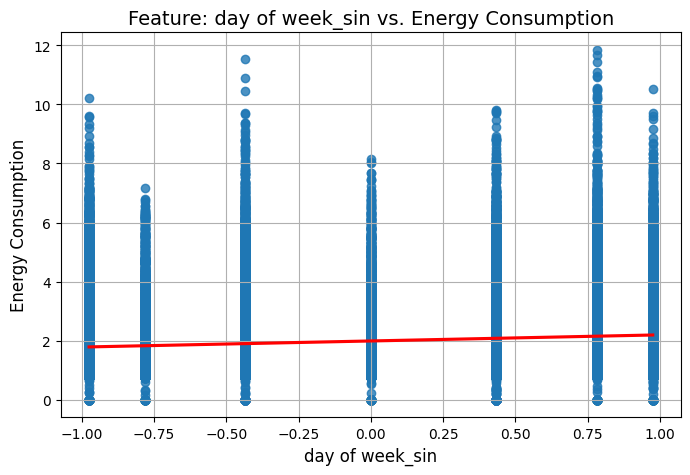

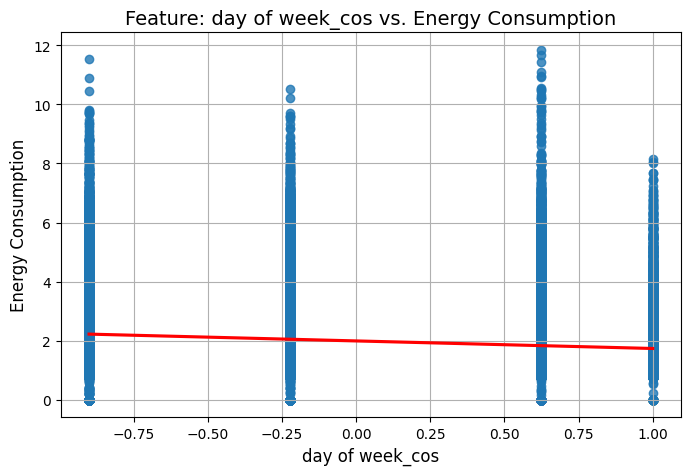

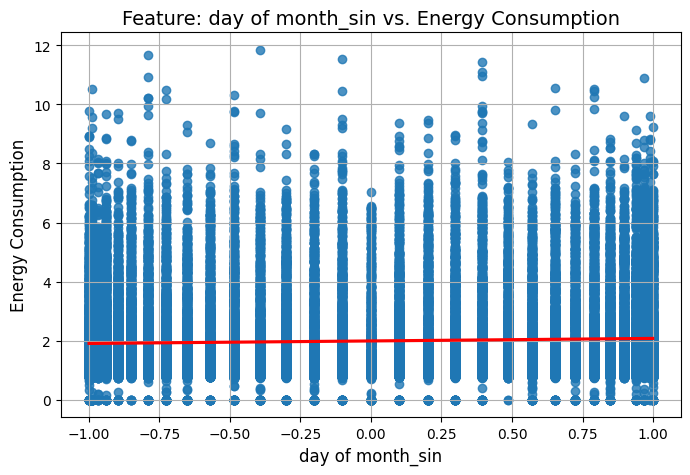

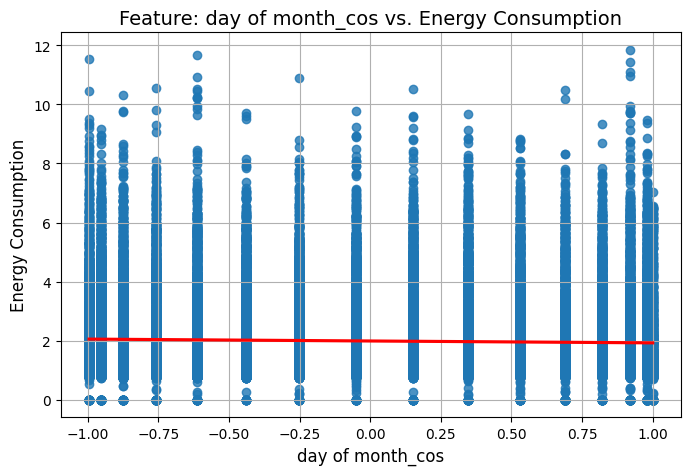

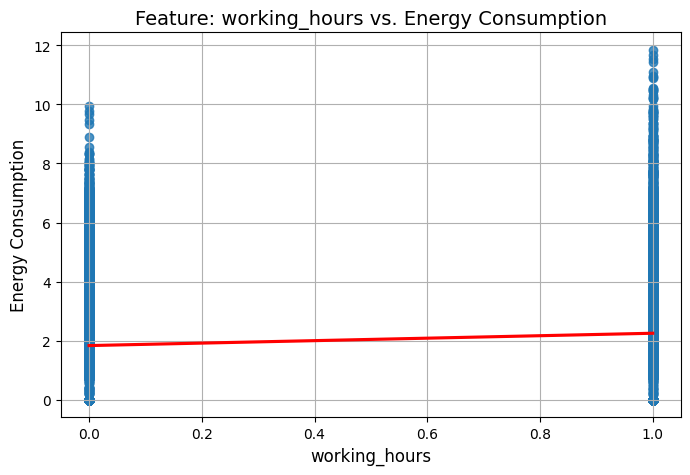

In [40]:
for feature_name in X.columns:
    plt.figure(figsize=(8, 5))  # Set the figure size for better readability
    sns.regplot(x=X[feature_name], y=y, line_kws={"color": "red"})  # Plot with linear regression line
    plt.title(f'Feature: {feature_name} vs. Energy Consumption', fontsize=14)  # Set title with feature name
    plt.xlabel(feature_name, fontsize=12)  # Label the x-axis with the feature name
    plt.ylabel('Energy Consumption', fontsize=12)  # Label the y-axis
    plt.grid(True)  # Enable grid for easier visualization
    plt.show()  # Display the plot

C:\Users\mscVRstudent22\AppData\Local\Temp\ipykernel_39540\4121684719.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


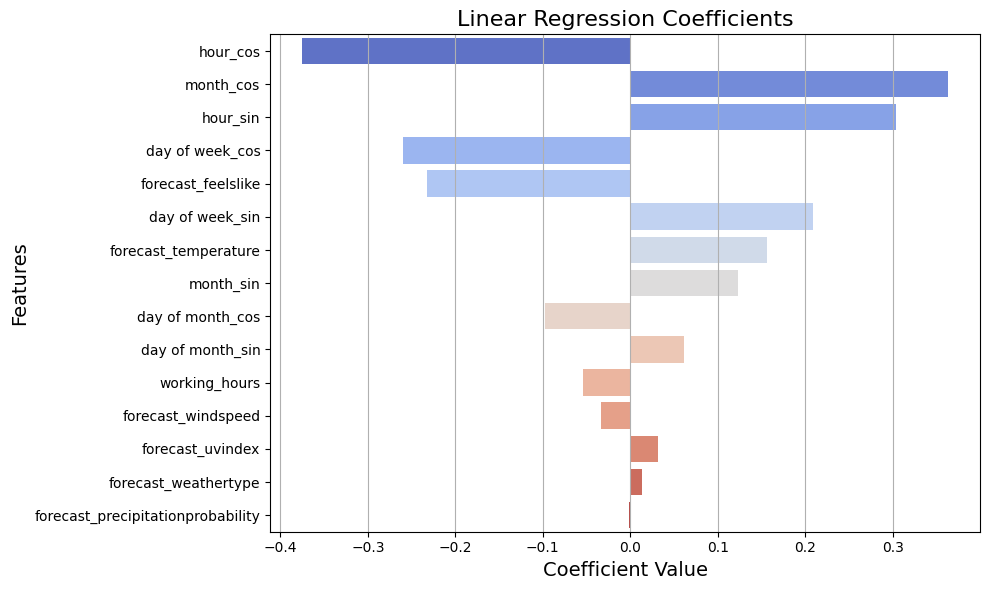

In [41]:
coefficients = lr_model.coef_

# Creating a DataFrame for easier plotting
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Sorting the DataFrame by the absolute values of coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title('Linear Regression Coefficients', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(True, axis='x')  # Adding a grid for x-axis for better readability
plt.tight_layout()  # Adjust layout to make sure everything fits without overlap

plt.show()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40766 entries, 112 to 41663
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   datepart                           40766 non-null  float64
 1   year                               40766 non-null  float64
 2   forecast_temperature               40766 non-null  float64
 3   forecast_feelslike                 40766 non-null  float64
 4   forecast_weathertype               40766 non-null  float64
 5   forecast_windspeed                 40766 non-null  float64
 6   forecast_uvindex                   40766 non-null  float64
 7   forecast_precipitationprobability  40766 non-null  float64
 8   month_sin                          40766 non-null  float64
 9   month_cos                          40766 non-null  float64
 10  hour_sin                           40766 non-null  float64
 11  hour_cos                           40766 non-null  float6

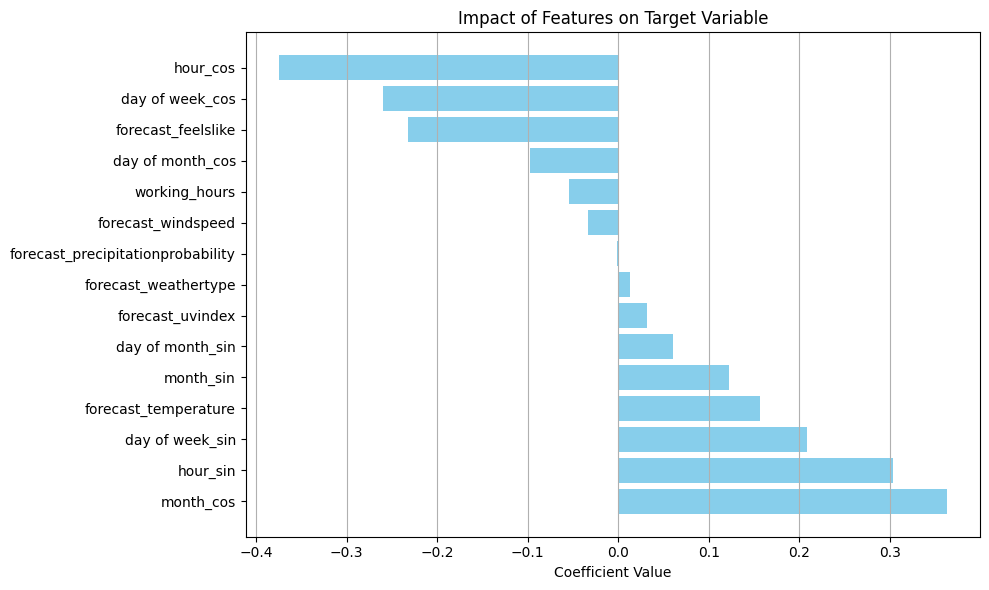

In [43]:
coefficients = lr_model.coef_
features = X.columns

coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Impact of Features on Target Variable')
plt.grid(axis='x')
plt.tight_layout()

In [46]:
import sklearn
print(sklearn.__version__)
from sklearn.inspection import plot_partial_dependence

# Your code for plotting

# Assuming `lr_model` is your trained model and `X` is your feature DataFrame
fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(lr_model, features=[0, 1], X=X, feature_names=features, ax=ax)
plt.tight_layout()


1.4.1.post1


ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (c:\AOB\AOB_Energy_Consumption_Analysis_Prediction\.venv\Lib\site-packages\sklearn\inspection\__init__.py)

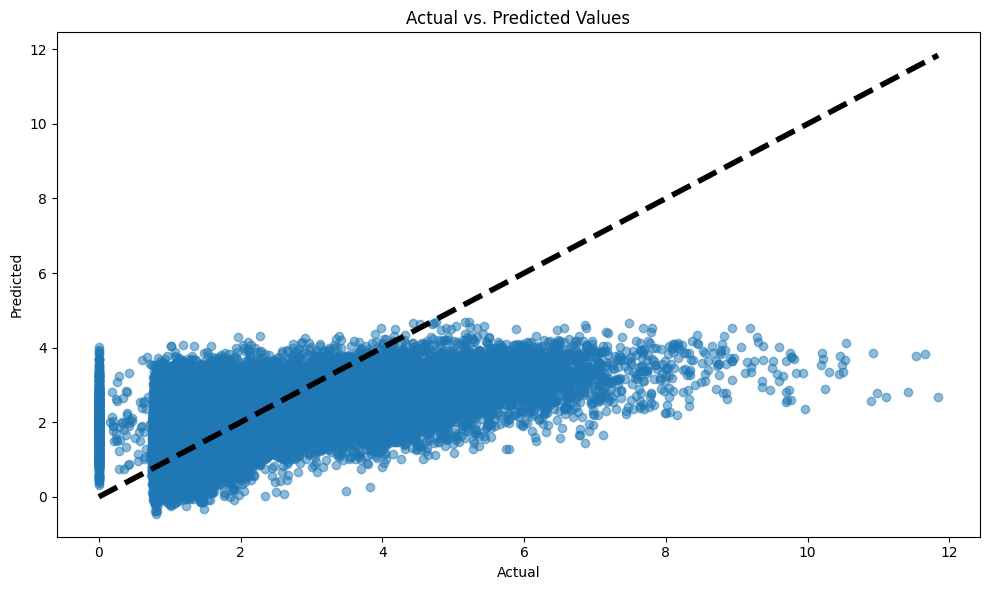

In [47]:
y_pred = lr_model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.tight_layout()
plt.show()


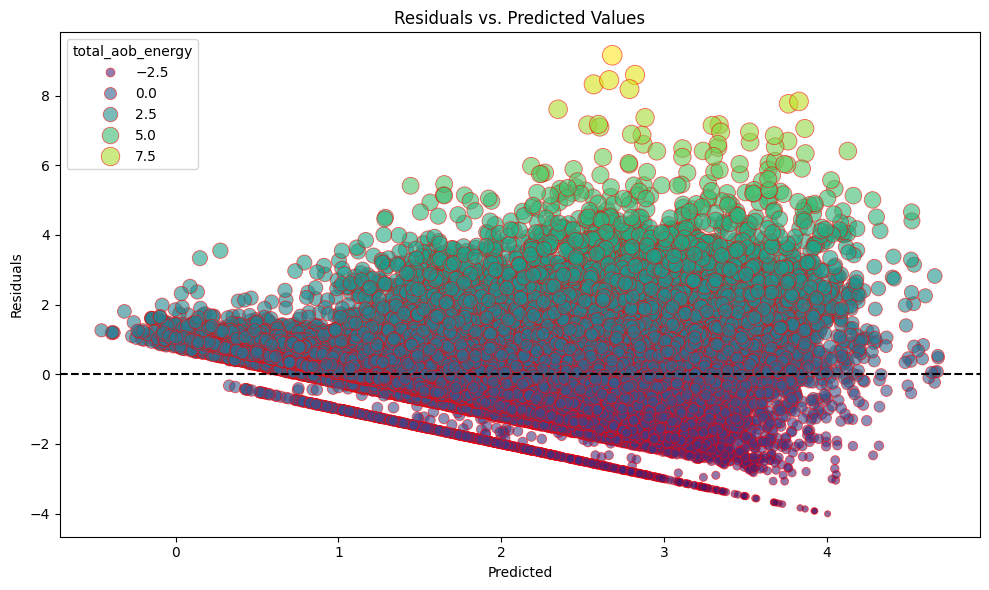

In [58]:
residuals = y - y_pred
# Use Seaborn to plot with a colormap reflecting point density
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor='red',
                palette='viridis', hue=residuals, size=residuals,
                sizes=(20, 200), legend=True)

plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

plt.tight_layout()
plt.show()

In [59]:
df

,datepart,year,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_windspeed,forecast_uvindex,forecast_precipitationprobability,month_sin,month_cos,hour_sin,hour_cos,day of week_sin,day of week_cos,day of month_sin,day of month_cos,working_hours,total_aob_energy
112,43560.0,2019.0,13.0,10.0,7.0,16.0,2.0,3.0,8.660254e-01,-0.5,-0.866025,-0.500000,-0.974928,-0.222521,8.486443e-01,0.528964,True,4.064825
113,43560.0,2019.0,13.0,10.0,7.0,16.0,2.0,3.0,8.660254e-01,-0.5,-0.965926,-0.258819,-0.974928,-0.222521,8.486443e-01,0.528964,False,3.487356
115,43560.0,2019.0,12.0,9.0,7.0,13.0,1.0,4.0,8.660254e-01,-0.5,-0.965926,0.258819,-0.974928,-0.222521,8.486443e-01,0.528964,False,1.962769
116,43560.0,2019.0,12.0,9.0,7.0,13.0,1.0,4.0,8.660254e-01,-0.5,-0.866025,0.500000,-0.974928,-0.222521,8.486443e-01,0.528964,False,1.704142
119,43560.0,2019.0,10.0,7.0,7.0,11.0,0.0,4.0,8.660254e-01,-0.5,-0.258819,0.965926,-0.974928,-0.222521,8.486443e-01,0.528964,False,1.872508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41659,45291.0,2023.0,10.0,6.0,15.0,22.0,0.0,96.0,-2.449294e-16,1.0,-0.965926,0.258819,0.000000,1.000000,-2.449294e-16,1.000000,False,1.079359
41660,45291.0,2023.0,10.0,6.0,15.0,22.0,0.0,97.0,-2.449294e-16,1.0,-0.866025,0.500000,0.000000,1.000000,-2.449294e-16,1.000000,False,2.365750
41661,45291.0,2023.0,11.0,7.0,15.0,34.0,0.0,96.0,-2.449294e-16,1.0,-0.707107,0.707107,0.000000,1.000000,-2.449294e-16,1.000000,False,2.376105
41662,45291.0,2023.0,11.0,7.0,15.0,34.0,0.0,96.0,-2.449294e-16,1.0,-0.500000,0.866025,0.000000,1.000000,-2.449294e-16,1.000000,False,2.342148


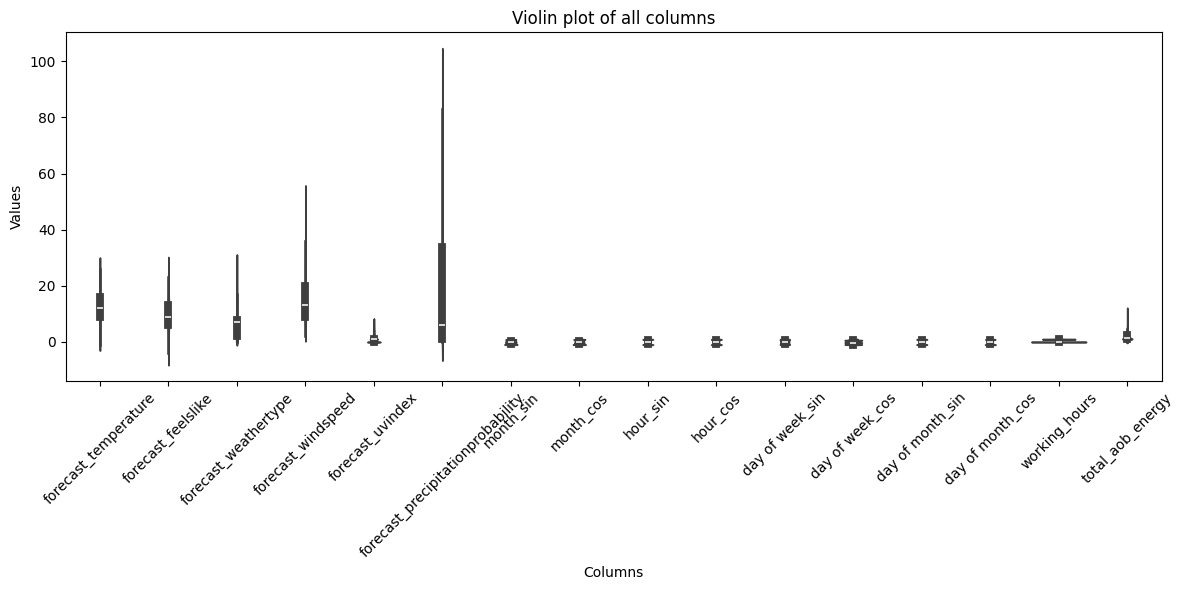

In [61]:
df = df.drop(['datepart', 'year'], axis = 1 )
# Melt the DataFrame from wide to long format
df_melted = pd.melt(df, var_name='Columns', value_name='Values')

# Plotting
plt.figure(figsize=(12, 6))
sns.violinplot(x='Columns', y='Values', data=df_melted)

plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.title('Violin plot of all columns')
plt.tight_layout()  # Adjust the layout
plt.show()

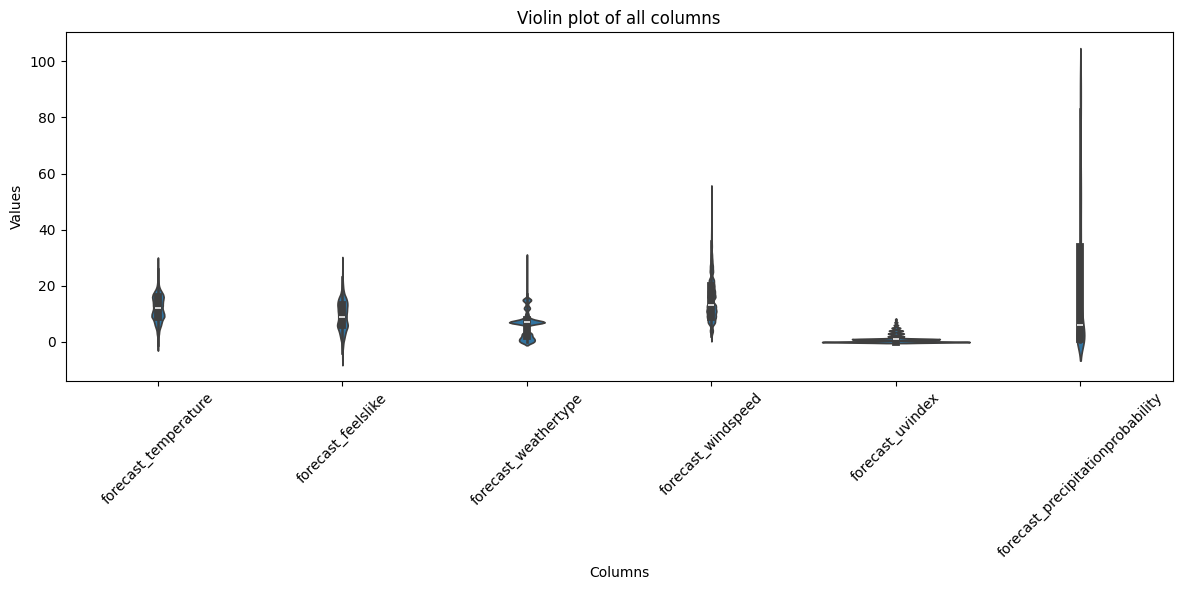

In [68]:
forecast_columns = [col for col in df.columns if col.startswith('forecast')]
df_forecast = df[forecast_columns]
# forecast_columns = pd.DataFrame(forecast_columns)
# Melt the DataFrame from wide to long format
df_melted = pd.melt(df_forecast, var_name='Columns', value_name='Values')

# Plotting
plt.figure(figsize=(12, 6))
sns.violinplot(x='Columns', y='Values', data=df_melted)

plt.xticks(rotation=45)  # Rotate the x labels for better readability
plt.title('Violin plot of all columns')
plt.tight_layout()  # Adjust the layout
plt.show()